<a href="https://colab.research.google.com/github/khanhlvg/tflite_raspberry_pi/blob/main/object_detection/Train_custom_model_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 The TensorFlow Authors.

In [1]:
!git clone https://github.com/kunal266/rhesus_final_pi_model.git

Cloning into 'rhesus_final_pi_model'...
remote: Enumerating objects: 1004, done.
remote: Counting objects: 100% (1004/1004), done.
remote: Compressing objects: 100% (513/513), done.
remote: Total 1004 (delta 491), reused 1004 (delta 491), pack-reused 0
Receiving objects: 100% (1004/1004), 16.08 MiB | 22.34 MiB/s, done.
Resolving deltas: 100% (491/491), done.


# Train a custom object detection model with TensorFlow Lite Model Maker

In this colab notebook, you'll learn how to use the [TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/guide/model_maker) to train a custom object detection model to detect Android figurines and how to put the model on a Raspberry Pi.

The Model Maker library uses *transfer learning* to simplify the process of training a TensorFlow Lite model using a custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data required and will shorten the training time.


## Preparation

### Install the required packages
Start by installing the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) and the pycocotools library you'll use for evaluation.

In [2]:
mv rhesus_final_pi_model/* ./

In [ ]:
!unzip Images.zip

In [3]:
!pip install -q tflite-model-maker
!pip install -q tflite-support

     |████████████████████████████████| 616 kB 11.2 MB/s 
     |████████████████████████████████| 120 kB 43.7 MB/s 
     |████████████████████████████████| 596 kB 45.8 MB/s 
     |████████████████████████████████| 87 kB 5.9 MB/s 
     |████████████████████████████████| 3.4 MB 46.9 MB/s 
     |████████████████████████████████| 77 kB 4.6 MB/s 
     |████████████████████████████████| 1.1 MB 38.4 MB/s 
     |████████████████████████████████| 237 kB 46.2 MB/s 
     |████████████████████████████████| 1.2 MB 37.7 MB/s 
     |████████████████████████████████| 1.1 MB 26.8 MB/s 
     |████████████████████████████████| 6.4 MB 41.9 MB/s 
     |████████████████████████████████| 840 kB 49.5 MB/s 
     |████████████████████████████████| 25.3 MB 2.4 MB/s 
     |████████████████████████████████| 352 kB 44.2 MB/s 
     |████████████████████████████████| 99 kB 8.9 MB/s 
     |████████████████████████████████| 47.8 MB 62 kB/s 
     |████████████████████████████████| 462 kB 49.4 MB/s 
     |███████████████

Import the required packages.

In [4]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat, QuantizationConfig
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

from tflite_support import metadata

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

### Prepare the dataset

This dataset contains about 70 images of 2 type of Android figurines: an Android and an Android pig. This is an example image from the dataset.

![android_figurine_sample.jpg](https://storage.googleapis.com/download.tensorflow.org/example_images/android_figurine_sample.jpg)

We start with downloading the dataset.

## Train the object detection model

### Step 1: Load the dataset

* Images in `train_data` is used to train the custom object detection model.
* Images in `val_data` is used to check if the model can generalize well to new images that it hasn't seen before.

In [ ]:
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
import os
path = 'Images/test'

for filename in os.listdir(path):
    if not filename.endswith('.xml'): continue
    fullname = os.path.join(path, filename)
    # tree = ET.parse(fullname)

    tree = ET.parse(fullname)
    root = tree.getroot()                                                
    # print(root)
    for bbb in tree.findall("./object/bndbox/xmin"):
    # print(bbb)
    # print("xmin is present")
    # print(bbb.text)
        bbb.text = str(int(float(bbb.text)))
    # print(bbb.text)


    for i in tree.findall("./object/bndbox/ymin"):
        i.text = str(int(float(i.text)))
    # print(ccc)
        # print(ccc.text)
    for ccc in tree.findall("./object/bndbox/xmax"):
        ccc.text = str(int(float(ccc.text)))
        print(ccc.text)

    # print(ddd)
        # print(ddd.text)
    


    for eee in tree.findall("./object/bndbox/ymax"):
    # print(eee)
        # print(eee.text)
        eee.text = str(int(float(eee.text)))
    tree.write(fullname)
    print(fullname)

In [43]:
!cat /content/Images/train/NyZwaWQ9QXBp%20(14).xml

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cat /content/Images/train/NyZwaWQ9QXBp%20(14).xml'


In [49]:
train_data = object_detector.DataLoader.from_pascal_voc(
    '/content/Images/train',
    '/content/Images/train',
    ['monkey']
)



In [52]:
val_data = object_detector.DataLoader.from_pascal_voc(
    '/content/Images/test',
    '/content/Images/test',
    ['monkey']
)

In [ ]:
mv /content/create_pascal_tfrecord.py /usr/local/lib/python3.7/dist-packages/tensorflow_examples/lite/model_maker/third_party/efficientdet/dataset

### Step 2: Select a model architecture

EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 146           | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 259           | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 396           | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 716           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 1886          | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Raspberry Pi 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>

In this notebook, we use EfficientDet-Lite0 to train our model. You can choose other model architectures depending on whether speed or accuracy is more important to you.

In [54]:
spec = model_spec.get('efficientdet_lite0')

### Step 3: Train the TensorFlow model with the training data.

* Set `epochs = 20`, which means it will go through the training dataset 20 times. You can look at the validation accuracy during training and stop when you see validation loss (`val_loss`) stop decreasing to avoid overfitting.
* Set `batch_size = 4` here so you will see that it takes 15 steps to go through the 62 images in the training dataset.
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [55]:
model = object_detector.create(train_data, model_spec=spec, batch_size=4, train_whole_model=True, epochs=20, validation_data=val_data)

Epoch 1/20
117/117 [==============================] - 82s 291ms/step - det_loss: 1.0978 - cls_loss: 0.6371 - box_loss: 0.0092 - reg_l2_loss: 0.0630 - loss: 1.1609 - learning_rate: 0.0065 - gradient_norm: 3.3245 - val_det_loss: 1.3136 - val_cls_loss: 0.7954 - val_box_loss: 0.0104 - val_reg_l2_loss: 0.0631 - val_loss: 1.3766
Epoch 2/20
117/117 [==============================] - 31s 261ms/step - det_loss: 0.7366 - cls_loss: 0.3954 - box_loss: 0.0068 - reg_l2_loss: 0.0631 - loss: 0.7997 - learning_rate: 0.0049 - gradient_norm: 3.6265 - val_det_loss: 0.6703 - val_cls_loss: 0.3309 - val_box_loss: 0.0068 - val_reg_l2_loss: 0.0632 - val_loss: 0.7334
Epoch 3/20
117/117 [==============================] - 31s 265ms/step - det_loss: 0.6455 - cls_loss: 0.3450 - box_loss: 0.0060 - reg_l2_loss: 0.0632 - loss: 0.7087 - learning_rate: 0.0048 - gradient_norm: 3.8276 - val_det_loss: 0.7306 - val_cls_loss: 0.4254 - val_box_loss: 0.0061 - val_reg_l2_loss: 0.0632 - val_loss: 0.7938
Epoch 4/20
117/117 [=====

### Step 4. Evaluate the model with the validation data.

After training the object detection model using the images in the training dataset, use the 10 images in the validation dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 64, it will take 1 step to go through the 10 images in the validation dataset.

The evaluation metrics are same as [COCO](https://cocodataset.org/#detection-eval).

In [56]:
model.evaluate(val_data)

1/1 [==============================] - 7s 7s/step



{'AP': 0.41532844,
 'AP50': 0.8642966,
 'AP75': 0.4089901,
 'AP_/monkey': 0.41532844,
 'APl': 0.45708093,
 'APm': 0.17937294,
 'APs': -1.0,
 'ARl': 0.58125,
 'ARm': 0.2,
 'ARmax1': 0.38333333,
 'ARmax10': 0.5388889,
 'ARmax100': 0.5388889,
 'ARs': -1.0}

### Step 5: Export as a TensorFlow Lite model.

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is [full integer quantization](https://www.tensorflow.org/lite/performance/post_training_integer_quant). This allows the TensorFlow Lite model to be smaller, run faster on Raspberry Pi CPU and also compatible with the Google Coral EdgeTPU.

In [57]:
model.export(export_dir='.', tflite_filename='android.tflite')

KeyboardInterrupt: ignored

### Step 6:  Evaluate the TensorFlow Lite model.

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop.
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [58]:
model.evaluate_tflite('rhesus.tflite', val_data)

27/27 [==============================] - 75s 3s/step



{'AP': 0.44945973,
 'AP50': 0.8859724,
 'AP75': 0.3552294,
 'AP_/monkey': 0.44945973,
 'APl': 0.47956145,
 'APm': 0.24912168,
 'APs': -1.0,
 'ARl': 0.56875,
 'ARm': 0.325,
 'ARmax1': 0.4,
 'ARmax10': 0.53055555,
 'ARmax100': 0.5416667,
 'ARs': -1.0}

In [ ]:
# Download the TFLite model to your local computer.
from google.colab import files
files.download('android.tflite')

## Test the Android figurine detection model

After training the model, let's test it with an image that the model hasn't seen before to get a sense of how good the model is.

In [60]:
#@title Run object detection and show the detection results

from PIL import Image

INPUT_IMAGE_URL = "/content/Images/test/VSZwaWQ9QXBp.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.5 #@param {type:"number"}
TFLITE_MODEL_PATH = "rhesus.tflite" #@param {type:"string"}
image = Image.open(INPUT_IMAGE_URL).convert('RGB')
image.thumbnail((512, 512), Image.ANTIALIAS)
image_np = np.asarray(image)

# Load the TFLite model
options = object_detector.ObjectDetector.ObjectDetectorOptions(
      num_threads=4,
      score_threshold=DETECTION_THRESHOLD,
)
detector = object_detector.ObjectDetector(model_path=TFLITE_MODEL_PATH)

# Run object detection estimation using the model.
# detections = detector.detect(image_np)

# # Draw keypoints and edges on input image
# image_np = visualize(image_np, detections)

# # Show the detection result
# Image.fromarray(image_np)

AttributeError: ignored

In [65]:
import cv2

from PIL import Image

model_path = 'rhesus.tflite'

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

In [63]:
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52


Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-09fe7800.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

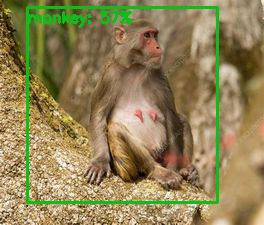

In [70]:
INPUT_IMAGE_URL = "/content/Images/test/VSZwaWQ9QXBp.jpg"
DETECTION_THRESHOLD = 0.5

# TEMP_FILE = '/tmp/image.png'

# !wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(INPUT_IMAGE_URL)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(INPUT_IMAGE_URL, 'PNG')
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    INPUT_IMAGE_URL,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)

## Compile the model for EdgeTPU

Finally, we'll compile the model using `edgetpu_compiler` so that the model can run on [Google Coral EdgeTPU](https://coral.ai/).

We start with installing the EdgeTPU compiler on Colab.

In [ ]:
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
!sudo apt-get update
!sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  40269      0 --:--:-- --:--:-- --:--:-- 40919
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:7 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 Packages
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.n

**Note:** When training the model using a custom dataset, beware that if your dataset includes more than 20 classes, you'll probably have slower inference speeds compared to if you have fewer classes. This is due to an aspect of the EfficientDet architecture in which a certain layer cannot compile for the Edge TPU when it carries more than 20 classes.

Before compiling the `.tflite` file for the Edge TPU, it's important to consider whether your model will fit into the Edge TPU memory. 

The Edge TPU has approximately 8 MB of SRAM for [caching model paramaters](https://coral.ai/docs/edgetpu/compiler/#parameter-data-caching), so any model close to or over 8 MB will not fit onto the Edge TPU memory. That means the inference times are longer, because some model parameters must be fetched from the host system memory.

One way to elimiate the extra latency is to use [model pipelining](https://coral.ai/docs/edgetpu/pipeline/), which splits the model into segments that can run on separate Edge TPUs in series. This can significantly reduce the latency for big models.

The following table provides recommendations for the number of Edge TPUs to use with each EfficientDet-Lite model.

| Model architecture | Minimum TPUs | Recommended TPUs
|--------------------|-------|-------|
| EfficientDet-Lite0 | 1     | 1     |
| EfficientDet-Lite1 | 1     | 1     |
| EfficientDet-Lite2 | 1     | 2     |
| EfficientDet-Lite3 | 2     | 2     |
| EfficientDet-Lite4 | 2     | 3     |

If you need extra Edge TPUs for your model, then update `NUMBER_OF_TPUS` here:

In [ ]:
NUMBER_OF_TPUS = 1

!edgetpu_compiler rhesus.tflite --num_segments=$NUMBER_OF_TPUS

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 3127 ms.

Input model: rhesus.tflite
Input size: 4.24MiB
Output model: rhesus_edgetpu.tflite
Output size: 5.57MiB
On-chip memory used for caching model parameters: 4.21MiB
On-chip memory remaining for caching model parameters: 3.29MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 267
Operation log: rhesus_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 264
Number of operations that will run on CPU: 3
See the operation log file for individual operation details.
Compilation child process c

Finally, we'll copy the metadata, including the label file, from the original TensorFlow Lite model to the EdgeTPU model.

In [ ]:
populator_dst = metadata.MetadataPopulator.with_model_file('rhesus_edgetpu.tflite')

with open('rhesus.tflite', 'rb') as f:
  populator_dst.load_metadata_and_associated_files(f.read())

populator_dst.populate()
updated_model_buf = populator_dst.get_model_buffer()

In [ ]:
# Download the TFLite model compiled for EdgeTPU to your local computer.
from google.colab import files
files.download('android_edgetpu.tflite')

In [ ]:
import cv2

from PIL import Image

model_path = 'rhesus.tflite'

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  scores = get_output_tensor(interpreter, 0)
  boxes = get_output_tensor(interpreter, 1)
  count = int(get_output_tensor(interpreter, 2))
  classes = get_output_tensor(interpreter, 3)

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path, 
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute 
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

NameError: ignored

In [ ]:
!python3 data_create.py

2022-04-24 05:48:55.554305: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Epoch 1/20
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/func_graph.py", line 1161, in func_graph_from_py_func
    func_outputs = python_func(*func_args, **func_kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/function.py", line 639, in _backprop_function
    src_graph=self._func_graph)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py", line 524, in _GradientsHelper
    gradient_uid)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py", line 221, in _DefaultGradYs
    new_grad_ys.append(array_ops.identity(grad_y, name="grad_ys_%d" % i))
KeyboardInterrupt

During handling of the above exception, another excep

In [ ]:
!rm -rf /content/sample_data

In [ ]:
!zip -r final_pi.zip /content/*

  adding: content/data_create.py (deflated 63%)
  adding: content/Images/ (stored 0%)
  adding: content/Images/test/ (stored 0%)
  adding: content/Images/test/ythgfdbvc.xml (deflated 60%)
  adding: content/Images/test/yhfsgbvfsv.xml (deflated 60%)
  adding: content/Images/test/YSZwaWQ9QXBp.xml (deflated 50%)
  adding: content/Images/test/YSZwaWQ9QXBp%20(1).jpg (deflated 1%)
  adding: content/Images/test/ytydgfgb.jpg (deflated 1%)
  adding: content/Images/test/ytytrhgfh.xml (deflated 65%)
  adding: content/Images/test/VSZwaWQ9QXBp.jpg (deflated 1%)
  adding: content/Images/test/WCZwaWQ9QXBp%20(1).xml (deflated 49%)
  adding: content/Images/test/ytjdhghgjghjb.xml (deflated 65%)
  adding: content/Images/test/yjytghnghfn.jpg (deflated 0%)
  adding: content/Images/test/YSZwaWQ9QXBp%20(1).xml (deflated 50%)
  adding: content/Images/test/yhgbv.jpg (deflated 0%)
  adding: content/Images/test/ythtrhnghmg.jpg (deflated 0%)
  adding: content/Images/test/YSZwaWQ9QXBp.jpg (deflated 1%)
  adding: co